# Training Linear Models

## Setup

First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

## Linear regression using the Normal Equation

In [6]:
import numpy as np

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

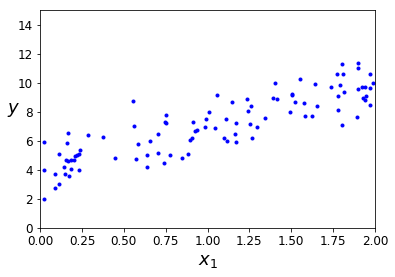

In [8]:
plt.plot(X, y, "b. ")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show();

**The Normal Equation**

$(X^T * X)^-1 * X^T * y$

In [9]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [12]:
X_b[:5]

array([[1.        , 0.20624774],
       [1.        , 1.80510581],
       [1.        , 1.01050474],
       [1.        , 1.65291493],
       [1.        , 0.6400992 ]])

In [13]:
theta_best

array([[4.03261915],
       [2.95352493]])

In [16]:
X_new = np.array([[0], [2]])
X_new_b = np.c_[np.ones((2, 1)), X_new]
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.03261915],
       [9.939669  ]])

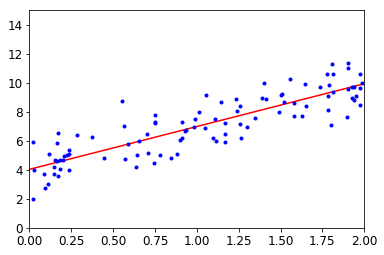

In [17]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([0, 2, 0, 15])
plt.show();

The figure in the book actually corresponds to the following code, with a legend and axis labels:

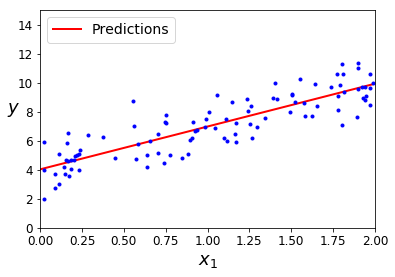

In [18]:
plt.plot(X_new, y_predict, "r-", linewidth=2, label="Predictions")
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 2, 0, 15])
plt.show();

In [20]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(array([4.03261915]), array([[2.95352493]]))

In [21]:
lin_reg.predict(X_new)

array([[4.03261915],
       [9.939669  ]])

The `LinearRegression` class is based on the `scipy.linalg.lstsq()` function (the name stands for "least squares"), which you could call directly:

In [22]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond=1e-6)
theta_best_svd

array([[4.03261915],
       [2.95352493]])

This function computes $\mathbf{X}^+\mathbf{y}$, where $\mathbf{X}^{+}$ is the _pseudoinverse_ of $\mathbf{X}$ (specifically the Moore-Penrose inverse). You can use `np.linalg.pinv()` to compute the pseudoinverse directly:

In [23]:
np.linalg.pinv(X_b).dot(y)

array([[4.03261915],
       [2.95352493]])

**Note**: the first releases of the book implied that the `LinearRegression` class was based on the Normal Equation. This was an error, my apologies: as explained above, it is based on the pseudoinverse, which ultimately relies on the SVD matrix decomposition of $\mathbf{X}$ (see chapter 8 for details about the SVD decomposition). Its time complexity is $O(n^2)$ and it works even when $m < n$ or when some features are linear combinations of other features (in these cases, $\mathbf{X}^T \mathbf{X}$ is not invertible so the Normal Equation fails), see [issue #184](https://github.com/ageron/handson-ml/issues/184) for more details. However, this does not change the rest of the description of the `LinearRegression` class, in particular, it is based on an analytical solution, it does not scale well with the number of features, it scales linearly with the number of instances, all the data must fit in memory, it does not require feature scaling and the order of the instances in the training set does not matter.

## Linear regression using batch gradient descent

In [24]:
eta = 0.1 # learning rate
n_iterations = 1000
m = 100
theta = np.random.randn(2, 1)

for i in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

In [25]:
theta

array([[4.03261915],
       [2.95352493]])

In [26]:
X_new_b.dot(theta)

array([[4.03261915],
       [9.939669  ]])

In [27]:
theta_path_bgd = []

def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_new_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
            
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        
        if theta_path is not None:
            theta_path.append(theta)
            
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

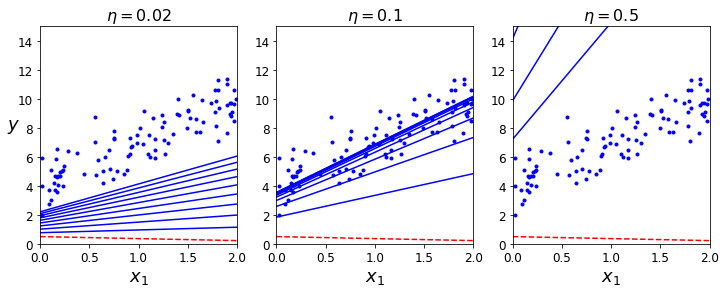

In [30]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(12, 4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show();

## Stochastic Gradient Descent

In [31]:
theta_path_sgd = []
m = len(X_b)
np.random.seed(42)

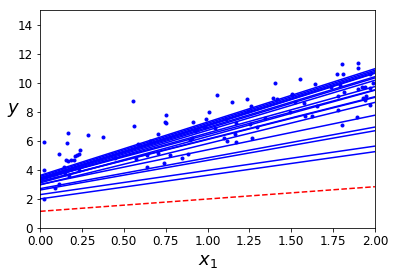

In [55]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2, 1)

for epoch in range(n_epochs):
    for i in range(m):
        if epoch == 0 and i < 20:
            y_predict = X_new_b.dot(theta)
            style = "b-" if i > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
        theta_path_sgd.append(theta)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([0, 2, 0, 15])
plt.show();

In [56]:
theta

array([[4.01131946],
       [2.94959222]])

In [61]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter=50, penalty=None, eta0=0.1, random_state=42)
sgd_reg.fit(X, y.ravel())

SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.1,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=50, n_iter=None, penalty=None,
       power_t=0.25, random_state=42, shuffle=True, tol=None, verbose=0,
       warm_start=False)

In [69]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.01665367]), array([2.92428491]))